# This notebook tries to find out thresholds for different methods based on their Dice scores

## This part is for our method (will need to change configs as we find better loss/arch etc.)

In [1]:
import argparse
import collections
import torch
import numpy as np
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
from trainer import VesselTrainer
from utils import dir2flow_2d, v2vesselness, overlay, overlay_quiver
from sklearn import metrics as M
from copy import deepcopy
import pickle as pkl

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)


class Args:
    def __init__(self):
#         self.config = 'configs/drivemaskv2_scale8.json'
#         self.config = 'configs/toydrive.json'
        self.config = 'configs/mloss/drivesq4.json'
        self.resume = None
        self.run_id = ''
        self.device = None

args = Args()

In [2]:
config = ConfigParser.from_args(args, '', parse=False)
# Augment some things here for dataloader
config.config['data_loader']['args']['augment'] = False
config.config['data_loader']['args']['shuffle'] = False
config.config['data_loader']['args']['batch_size'] = 1
config.config['data_loader']['args']['validation_split'] = 0
config.config['data_loader']['args']['toy'] = False

# config.config['optimizer']['args']['lr'] = 1e-2
# config.config['arch']['type'] = 'DeepLabV3'

data_loader = config.init_obj('data_loader', module_data)
config.config['data_loader']['args']['toy'] = True
gt_loader = config.init_obj('data_loader', module_data)

model = config.init_obj('arch', module_arch).cuda()
criterion = getattr(module_loss, config['loss'])
metrics = [getattr(module_metric, met) for met in config['metrics']]

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)


backup_config = deepcopy(config)


In [3]:
print(dict(config['loss_args']))
# Change loss args here
pass
# config.config['loss_args']['lambda_intensity'] = 1
# config.config['loss_args']['lambda_consistency'] = 1

{'num_directions': 2, 'eps': 0.1, 'uncertainty': False, 'loss_intensity': 'L2', 'lambda_intensity': 0.1, 'lambda_consistency': 0.2, 'lambda_cosine': 1, 'lambda_decoder': 1, 'lambda_length': 1, 'lambda_template': 5, 'is_crosscorr': True, 'use_mask': True, 'detach': True, 'num_samples_template': 12, 'lambda_followupv': 0, 'lambda_perlength': 0.1}


In [4]:
%pylab
%matplotlib inline

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [5]:
def dice_score(a, b):
    num = (2*a*b).sum()
    den = a.sum() + b.sum()
    return num/den

In [6]:
# mask = data['mask'][0, 0].data.cpu().numpy()
# g = gt[0, 0].data.cpu().numpy()
# g = (g > 0.5).astype(float)

# Frangi

Here we'll try to determine the best threshold for Frangi in a similar way.

In [10]:
from skimage.filters import frangi

frangi_thres = []

for i, (data, gt) in enumerate(zip(data_loader, gt_loader)):
    img = data['image'].data.cpu().numpy()[0, 0]
    mask = data['mask'][0, 0].data.cpu().numpy()
    gt = gt['image'][0, 0].data.cpu().numpy()
    g = (gt > 0.5).astype(float)
    
#     plt.subplot(121)
#     plt.imshow(img)
#     plt.subplot(122)
#     plt.imshow(g)
#     break
    # frangi
    frangives = frangi(img, np.linspace(1, 5, 10), black_ridges=True).astype(np.float32)*mask
    fpr, tpr, thres = M.roc_curve(g.reshape(-1).astype(int), frangives.reshape(-1), pos_label=1)
    auc = M.auc(fpr, tpr)
    print(auc)
    # Get optimal threshold
    dice = []
    N = 10
    for t in thres[::N]:
        vthres = (frangives > t).astype(float)
        # Given thresholded image, get dice score
        d = dice_score(vthres, g)
        dice.append(d)
    # get maximum threshold
    f_max_idx = np.argmax(dice)
    f_max_thres = thres[N*f_max_idx]
    f_max_d = dice[f_max_idx]
    print("Maximum dice score: {} achieved at threshold = {}".format(f_max_d, f_max_thres))
    frangi_thres.append(f_max_thres)
    
    if i == 4:
        break


0.9481921363930657
Maximum dice score: 0.6814178302900108 achieved at threshold = 2.8326542178547243e-07
0.9340157409052221
Maximum dice score: 0.6787367053665665 achieved at threshold = 2.326846129108162e-07
0.9216947508942686
Maximum dice score: 0.5490250387768668 achieved at threshold = 7.063941893648007e-07
0.9335433187822944
Maximum dice score: 0.7068417744100307 achieved at threshold = 2.974100539177016e-07
0.9018702013859321
Maximum dice score: 0.6712416094798815 achieved at threshold = 8.365894643702632e-08


In [11]:
'''
Determine average accuracy from given threshold
'''
frangi_acc = []
frangi_auc = []
frangi_dice = []
frangi_sp = []
frangi_se = []
frangi_avg_thres = np.mean(frangi_thres)
print(frangi_avg_thres)

for i, (data, gt) in enumerate(zip(data_loader, gt_loader)):
    img = data['image'].data.cpu().numpy()[0, 0]
    mask = data['mask'][0, 0].data.cpu().numpy()
    gt = gt['image'][0, 0].data.cpu().numpy()
    g = (gt > 0.5).astype(float)
    
    frangives = frangi(img, np.linspace(1, 5, 10), black_ridges=True).astype(np.float32)*mask
    frangiV = (frangives >= frangi_avg_thres).astype(float)
    fpr, tpr, thres = M.roc_curve(g.reshape(-1).astype(int), frangives.reshape(-1), pos_label=1)
    auc = M.auc(fpr, tpr)
    frangi_auc.append(auc)
    
    frangi_dice.append(dice_score(frangiV, g))
    
    # Calculate metrics
    acc = (frangiV == g).mean()
    tn = ((frangiV == 0)*(g == 0)).mean()
    tp = ((frangiV == 1)*(g == 1)).mean()
    fp = ((frangiV == 1)*(g == 0)).mean()
    fn = 1 - tn - tp - fp
    sp, se = tn/(tn+fp), tp/(tp + fn)
    # Append
    frangi_acc.append(acc)
    frangi_sp.append(sp)
    frangi_se.append(se)

print("AUC: {:4f}, Dice: {:4f}, Acc: {:4f}, Sp: {:4f}, Se: {:4f}".format( \
                    np.mean(frangi_auc), np.mean(frangi_dice), \
                    np.mean(frangi_acc), np.mean(frangi_sp), np.mean(frangi_se)))

3.2068266e-07
AUC: 0.932351, Dice: 0.637316, Acc: 0.936173, Sp: 0.964623, Se: 0.639799


--------------
# Vesselness from file

In [6]:
# with open('./drivec4_10.pkl', 'rb') as fi:
# with open('./drivesqcontrast8.pkl', 'rb') as fi:
# with open('./drive_sq8_300.pkl', 'rb') as fi:
# with open('drive_contrast8_525.pkl', 'rb') as fi:
# with open('drivesqnormal4_v1-1110-200/train_vesselness.pkl', 'rb') as fi:
with open('train_vesselness.pkl', 'rb') as fi:
    data_ = pkl.load(fi)
    data_ = (data_ - data_.min())/(data_.max() - data_.min())

In [7]:
our_thres = []

for i, (datum, gt) in enumerate(zip(data_, gt_loader)):
    mask = gt['mask'][0, 0].data.cpu().numpy()
    gt = gt['image'][0, 0].data.cpu().numpy()
    g = (gt > 0.5).astype(float)
    datum = datum[0]

    # Get AUC here
    fpr, tpr, thres = M.roc_curve(g.reshape(-1).astype(int), (datum).reshape(-1), pos_label=1)
    auc = M.auc(fpr, tpr)
    print(auc)

    # Get optimal threshold
    dice = []
    N = 10
    for t in thres[::N]:
        vthres = (datum > t).astype(float)
        # Given thresholded image, get dice score
        d = dice_score(vthres, g)
        dice.append(d)
        
    # get maximum threshold
    f_max_idx = np.argmax(dice)
    f_max_thres = thres[N*f_max_idx]
    f_max_d = dice[f_max_idx]
    print("Maximum dice score: {} achieved at threshold = {}".format(f_max_d, f_max_thres))
    our_thres.append(f_max_thres)
    if i == 4:
        break

0.9696936818944112
Maximum dice score: 0.7746879565317683 achieved at threshold = 0.11779820919036865
0.9614721749644017
Maximum dice score: 0.7594704249412769 achieved at threshold = 0.11222419142723083
0.9418202028854553
Maximum dice score: 0.590196025121666 achieved at threshold = 0.14266261458396912
0.9595584283886215
Maximum dice score: 0.7719987455226713 achieved at threshold = 0.1096988096833229
0.9465730171158974
Maximum dice score: 0.7547475730123021 achieved at threshold = 0.09905213117599487


In [8]:
'''
Determine average accuracy from given threshold
'''
our_acc = []
our_dice = []
our_auc = []
our_sp = []
our_se = []
our_avg_thres = np.mean(our_thres)
print(our_avg_thres)

for i, (datum, gt) in enumerate(zip(data_, gt_loader)):
    mask = gt['mask'][0, 0].data.cpu().numpy()
    gt = gt['image'][0, 0].data.cpu().numpy()
    g = (gt > 0.5).astype(float)
    datum = datum[0]
    
    fpr, tpr, thres = M.roc_curve(g.reshape(-1).astype(int), (datum).reshape(-1), pos_label=1)
    auc = M.auc(fpr, tpr)
    our_auc.append(auc)
    
    datum = (datum > our_avg_thres).astype(float)    
    our_dice.append(dice_score(datum, g))
    
    # Calculate metrics
    acc = (datum == g).mean()
    tn = ((datum == 0)*(g == 0)).mean()
    tp = ((datum == 1)*(g == 1)).mean()
    fp = ((datum == 1)*(g == 0)).mean()
    fn = 1 - tn - tp - fp
    sp, se = tn/(tn+fp), tp/(tp + fn)
    # Append
    our_acc.append(acc)
    our_sp.append(sp)
    our_se.append(se)

# print("Frangi AUC: {:4f}, Dice: {:4f}, Acc: {:4f}, Sp: {:4f}, Se: {:4f}".format( \
#                     np.mean(frangi_auc), np.mean(frangi_dice), \
#                     np.mean(frangi_acc), np.mean(frangi_sp), np.mean(frangi_se)))
print("Ours AUC: {:4f}, Dice: {:4f}, Acc: {:4f}, Sp: {:4f}, Se: {:4f}".format( \
                    np.mean(our_auc), np.mean(our_dice), \
                    np.mean(our_acc), np.mean(our_sp), np.mean(our_se)))


0.11628719
Ours AUC: 0.957547, Dice: 0.721545, Acc: 0.950878, Sp: 0.972973, Se: 0.722275


(-0.5, 511.5, 511.5, -0.5)

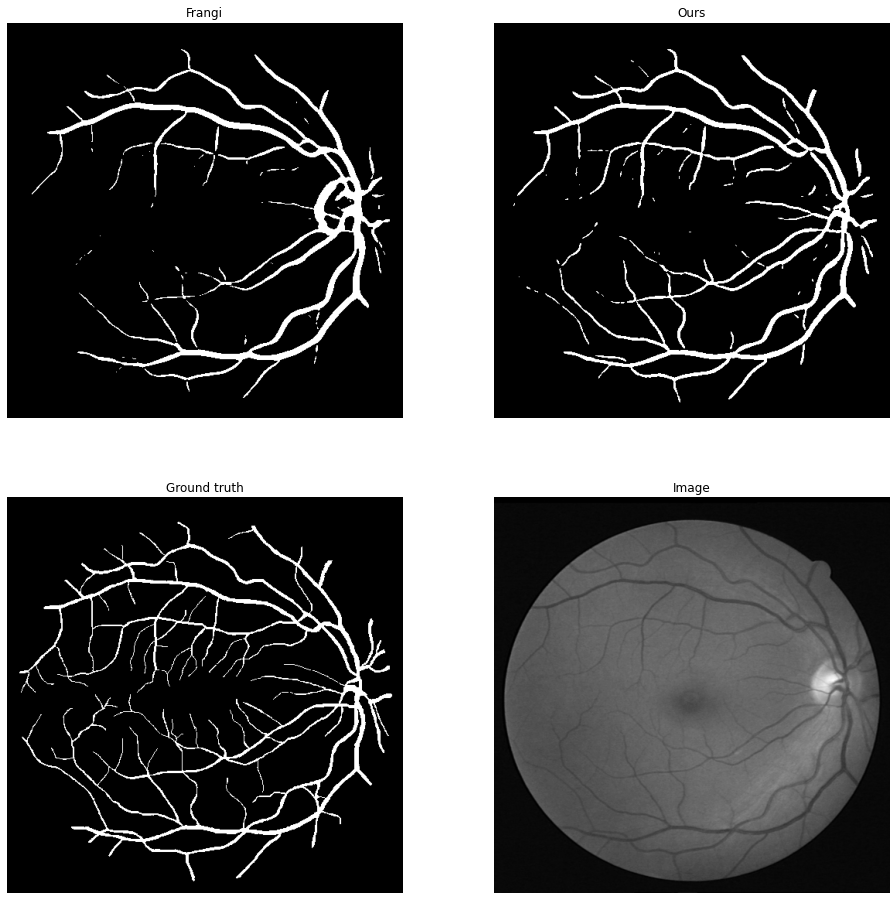

In [14]:
plt.figure(figsize=(16, 16))
plt.subplot(222)
plt.imshow(datum, 'gray')
plt.title("Ours")
plt.axis('off')

plt.subplot(221)
plt.imshow(frangiV, 'gray')
plt.title("Frangi")
plt.axis('off')

plt.subplot(223)
plt.imshow(g, 'gray')
plt.title("Ground truth")
plt.axis('off')


plt.subplot(224)
plt.imshow(img, 'gray')
plt.title("Image")
plt.axis('off')

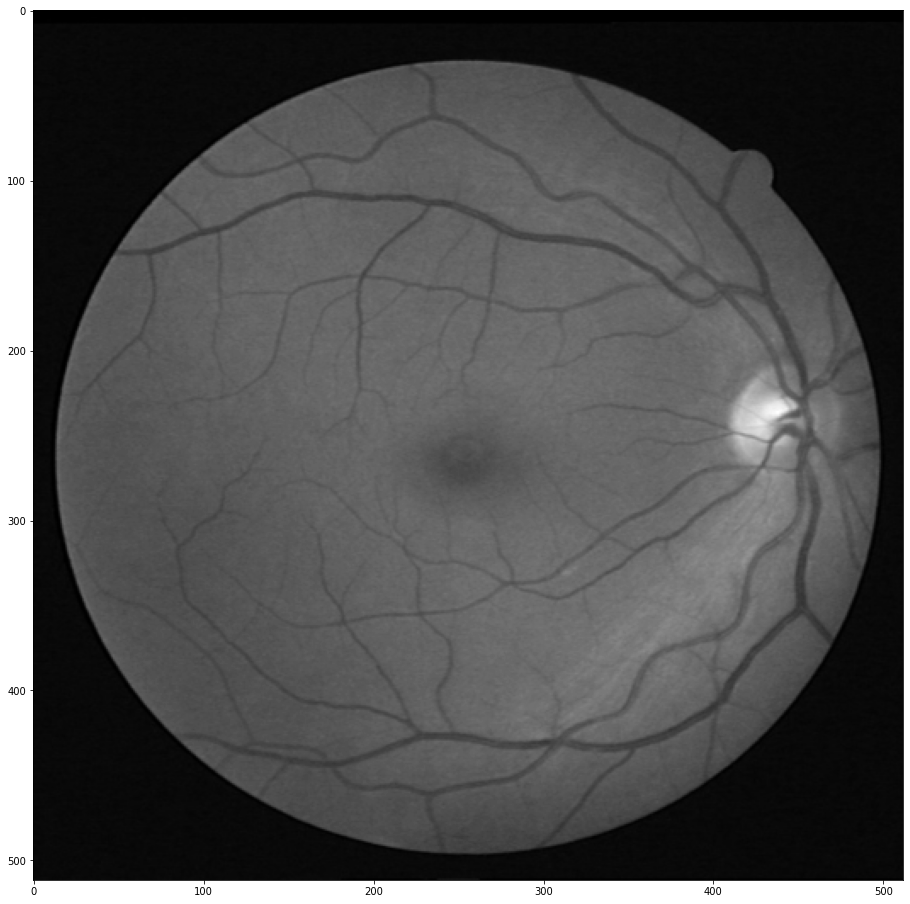

In [71]:
plt.figure(figsize=(16, 16))
plt.imshow(img, 'gray')